## Credit Scoring Introdução

Esse projeto conta com uma base de dados de uma empresa da área de crédito.

Nesta base, podemos identificar diversas informações sobre cada empréstimo e alguns dados cadastrais dos clientes.

Meu objetivo é ajustar um modelo que consiga auxiliar a empresa na classificação de bons e maus pagadores. Evitando, principalmente, a categorização errônea de bons pagadores, ou seja, evitando falsos positivos, já que estes representam um alto custo à empresa.

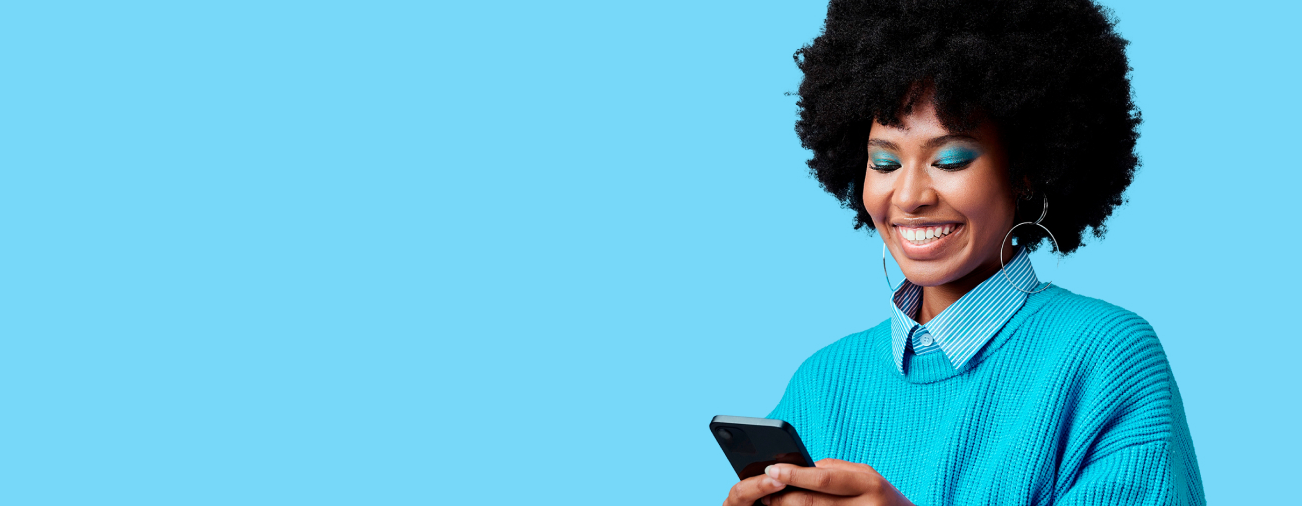

----------------------------------------------------------------------------------------------------------------------------------------------------------------

## Bibliotecas utilizadas

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, make_scorer
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay

----------------------------------------------------------------------------------------------------------------------------------------------------------------

## Importação / conhecendo os dados

In [41]:
dados = pd.read_excel('/content/Case Open (3).xlsx', sheet_name='Base')
dados_bad=dados.query('bad==1')
dados_good=dados.query('bad==0')
dados

,id,estado,setor,faturamento_informado,divida_total_pj,score,taxa,atraso_corrente,prazo,valor_contrato,valor_contrato_mais_juros,valor_em_aberto,score/2,loss,bad
0,2230,SP,ATACADO,400000.0,409000.0,167,4.3470,0,12.6,44633.5995,51828.48,0.00,21,0.000000,0
1,22408,CE,VAREJO,150000.0,18000.0,135,5.1240,0,12.6,8877.6555,10776.72,0.00,19,0.000000,0
2,25129,SP,INDUSTRIA DA CONSTRUCAO,60000.0,0.0,726,4.0635,0,12.6,16645.5975,19063.08,0.00,62,0.000000,0
3,31369,TO,VAREJO,60000.0,116000.0,298,4.6935,0,12.6,16739.0475,19877.28,0.00,34,0.000000,0
4,39775,RJ,VAREJO,1500000.0,1086000.0,525,4.2000,0,12.6,112659.5610,128793.72,0.00,51,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,88467,RJ,SERVICOS DE SAUDE,90000.0,0.0,388,5.1765,1291,12.6,11161.4895,13728.48,13728.48,39,1.000000,1
1921,96123,SP,TRANSPORTE,14196.0,25000.0,884,4.4310,0,6.3,2163.8505,2376.42,0.00,88,0.000000,0
1922,107155,SC,VAREJO,75000.0,136000.0,364,4.7145,0,12.6,16645.7970,19791.00,0.00,36,0.000000,0
1923,114376,ES,VAREJO,16000.0,4000.0,109,6.5835,1207,6.3,5408.5185,6241.32,5201.10,11,0.833333,1


----------------------------------------

Ao explorar os dados, conseguimos perceber que há poucos dados cadastrais, enquanto a maior parte dos valores são referentes ao empréstimo corrente.

Outro detalhe é que a empresa já possui um scoring próprio.

Desta forma, iremos remover todos os valores relacionados aos empréstimos, mantendo apenas a classificação de adimplentes ou inadimplentes e dados cadastrais.

Para, então, buscar uma relação entre os dados cadastrais e a categorização daquele cliente, ajustando um modelo que serviria de suporte nas decisões da empresa.

----------------------------------------

É possível observar que maus pagadores possuem, em média, maior faturamento e maior dívida, apesar do grande desvio padrão. E também podemos utilizar a representatividade negativa dentro de cada variável categórica para tentar chegar num modelo que se adapte às características dos clientes típicos dessa empresa.

----------------------------------------

## Tratamento dos dados e manipulação dos DataFrames

In [42]:
df=dados.drop(columns=dados.columns[5:-1])
df=df.drop(columns=df.columns[0])
df_estados_intra_porcent_bad=df[['estado', 'bad']].groupby('bad').value_counts()[1]/(df[['estado', 'bad']].groupby('bad').value_counts()[0]+df[['estado', 'bad']].groupby('bad').value_counts()[1])
df_estados_intra_porcent_bad.RR=0
df_estados_intra_porcent_bad=(df_estados_intra_porcent_bad*100).sort_values(ascending=False).to_frame()
mapeamento_estados=df_estados_intra_porcent_bad['count'].to_dict()
df['prob_estado']=df['estado'].map(mapeamento_estados)
df.setor=df.setor.fillna('desconhecido')

dict_setores = {'VAREJO': 29.35,
 'SERVICOS DE ALOJAMENTO/ALIMENTACAO': 36.72,
 'SERVICOS ADMINISTRATIVOS': 22.76,
 'SERVICOS PROFISSIONAIS E TECNICOS': 24.11,
 'ATACADO': 31.82,
 'INDUSTRIA DA CONSTRUCAO': 36.17,
 'BENS DE CONSUMO': 31.8,
 'SERVICOS DIVERSOS': 25.93,
 'TRANSPORTE': 27.42,
 'INDUSTRIA DIGITAL': 24.07,
 'SERVICOS DE EDUCACAO': 21.15,
 'TELECOM': 8.7,
 'SERVICOS DE SAUDE': 17.65,
 'SIDERURGICA-METALURGIA': 37,
 'QUIMICA-PETROQUIMICA': 16.67,
 'TEXTEIS': 23.08,
 'PAPEL E CELULOSE': 20.01,
 'BENS DE CAPITAL': 12.5,
 'DIVERSOS': 25,
 'PRODUTOS DE AGROPECUARIA': 14.29,
 'ELETROELETRONICOS': 20.0,
 'desconhecido': 1,
 'INDUSTRIA AUTOMOTIVA': 1,
 'SERVICOS DE SANEAMENTO BASICO': 1,
 'MINERACAO': 1,
 'ENERGIA': 1}

df['prob_setor']=df['setor'].map(dict_setores)

#ONE HOT ENCODER
df_2 = df
df_2.setor.fillna(1, inplace=True)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
dados_transformados = encoder.fit_transform(df_2[['estado', 'setor']])
colunas = encoder.get_feature_names_out(['estado', 'setor'])
df_one_hot = pd.DataFrame(dados_transformados, columns=colunas)
df_2_final = pd.concat([df_2, df_one_hot], axis=1)
df_2_final = df_2_final.drop(columns=['estado', 'setor'])

df_2_final

,faturamento_informado,divida_total_pj,bad,prob_estado,prob_setor,estado_AC,estado_AL,estado_AM,estado_AP,estado_BA,...,setor_SERVICOS DE SANEAMENTO BASICO,setor_SERVICOS DE SAUDE,setor_SERVICOS DIVERSOS,setor_SERVICOS PROFISSIONAIS E TECNICOS,setor_SIDERURGICA-METALURGIA,setor_TELECOM,setor_TEXTEIS,setor_TRANSPORTE,setor_VAREJO,setor_desconhecido
0,400000.0,409000.0,0,26.271186,31.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,150000.0,18000.0,0,22.916667,29.35,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60000.0,0.0,0,26.271186,36.17,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60000.0,116000.0,0,38.461538,29.35,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1500000.0,1086000.0,0,28.082192,29.35,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,90000.0,0.0,1,28.082192,17.65,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1921,14196.0,25000.0,0,26.271186,27.42,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1922,75000.0,136000.0,0,31.506849,29.35,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1923,16000.0,4000.0,1,32.258065,29.35,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Aqui, separei os dados de interesse para que não houvesse vazamento de variáveis.

Duas colunas foram criadas, contendo a representatividade da inadimplência em cada variável categórica para auxiliar o modelo na decisão final.

E one hot encoder foi aplicado para identificação binária das variáveis categóricas

## Construção do modelo auxiliar de decisão

In [64]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df_2_final.drop('bad', axis=1), df_2_final['bad'], test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
#print(classification_report(y_test, model.predict(X_test)))
# Obter as probabilidades de ser GOOD (0)
y_prob = model.predict_proba(X_test)[:, 0]
confusion_matrix(y_test, model.predict(X_test))
cost_matrix = np.array([[0, 2], [4, 0]])
cost_matrix
#calculando custos para diferentes limiares e determinando threshold ideal
# testasso=np.arange(0.1, 0.99, 0.001)

# for t in testasso:
#  iter_prob=[0 if i>=t else 1 for i in y_prob]
#  iter_prob=np.array(iter_prob)

#  conf_matrix=confusion_matrix(y_test, iter_prob)

#  total_cost=np.sum(conf_matrix*cost_matrix)
#  if total_cost<=428:
#   print(t, total_cost)
#calculando custos para diferentes limiares e determinando threshold ideal
t=0.5050000000000003
iter_prob=[0 if i>=t else 1 for i in y_prob]
iter_prob=np.array(iter_prob)

conf_matrix=confusion_matrix(y_test, iter_prob)

total_cost=np.sum(conf_matrix*cost_matrix)

##Análise de desempenho


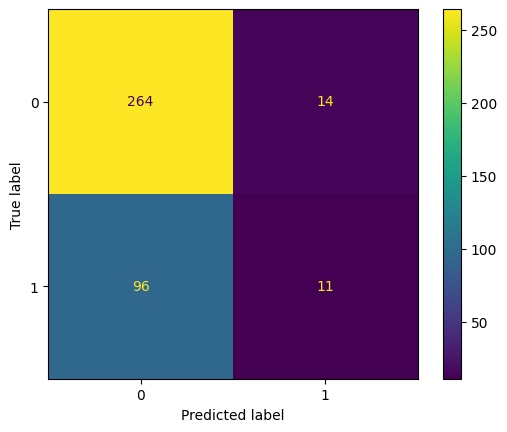

In [65]:
#Matriz de confusão

previsoes = model.predict(X_test)
matriz_confusao=confusion_matrix(y_test,
                                     iter_prob, labels=None,
                                     sample_weight=None, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao,
                              display_labels=None)
disp.plot()
plt.show()

O resultado mostra um acerto de 64% dos adimplentes. Este era o objetivo principal.

A relação dos inadimplentes não nos interessa tanto devido a natureza dessa análise, que possui a finalidade de evitar perdas por parte da empresa.

Queremos, principalmente, evitar a concessão de crédito àqueles que possam trazer prejuízos. Desta forma, chegamos a este modelo que oferece forte auxílio nessa decisão.

Com 64% de acerto, é possível utilizá-lo como um filtro facilitador, que irá trazer mais embasamento à decisão final.

----------------------------------------